Import libraries

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

Load data and explore years

In [9]:
train_data = pd.read_json("train.json")
train_data.head()

,authors,year,abstract,venue,title
0,"[42, 13720, 36]",9,"[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",20,"[41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1..."
1,"[1359, 15881, 45]",15,"[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",2,"[1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3..."
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159..."
3,[97],10,"[46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...",4,"[40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5..."
4,"[19617, 2]",10,"[37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...",9,"[38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,..."


In [10]:
test_data = pd.read_json("test.json")
test_data.head(5)

,identifier,coauthors,year,abstract,venue,title
0,0,"[16336, 1762, 4357, 12564]",19,"[37, 1662, 3207, 10, 33, 2037, 1738, 1642, 155...",223,"[3207, 24, 1798, 1738, 37, 2375, 1568, 11, 53,..."
1,1,"[21189, 14088]",19,"[1731, 2130, 3674, 1705, 1656, 3077, 1546, 367...",223,"[40, 1560, 1536, 1544, 1609, 1705, 1658, 1543,..."
2,2,"[3625, 1198, 19889, 794, 2749, 7801]",19,"[1551, 1728, 3920, 1542, 1535, 1656, 1543, 153...",7,"[47, 1574, 1729, 1641, 11, 37, 2533, 2015, 47,..."
3,3,"[19810, 15173, 5876, 111]",19,"[51, 1535, 2115, 1543, 1811, 1700, 1657, 1684,...",21,"[1770, 53, 2054, 1549, 1529, 1723, 2796, 1547,..."
4,4,"[10932, 7668, 11907, 19601, 15307, 10492, 1049...",19,"[1775, 1746, 1842, 1525, 33, 2551, 1882, 1542,...",,"[18, 1924, 23, 1544, 3927, 2686, 1543, 1535, 1..."


(array([  0.,   0.,   0.,   0.,   0., 800.,   0.,   0.,   0.,   0.]),
 array([18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4, 19.5]),
 <BarContainer object of 10 artists>)

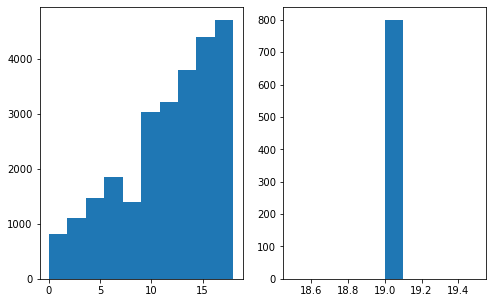

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].hist(train_data["year"].values)
axes[1].hist(test_data["year"].values)

In [12]:
test_venues = test_data["venue"].values
test_venues[test_venues == ''] = '-1'

In [13]:
unique, counts = np.unique(test_venues.astype(int), return_counts=True) 
dict(zip(unique, counts))

{-1: 91,
 0: 187,
 5: 7,
 7: 117,
 13: 11,
 17: 6,
 18: 9,
 21: 41,
 31: 16,
 56: 3,
 59: 29,
 63: 5,
 105: 8,
 106: 4,
 122: 4,
 161: 1,
 197: 5,
 223: 164,
 224: 1,
 234: 4,
 235: 15,
 263: 2,
 367: 6,
 431: 20,
 447: 5,
 455: 1,
 458: 9,
 459: 8,
 460: 6,
 461: 5,
 462: 5,
 463: 3,
 464: 2}

Helper functions for input/output format and scoring

In [134]:
def get_prolific_authors(authors):
    """Filter a list of authors to contain prolific authors only (ID < 100)

    Parameters
    ----------        
    authors : 
        A list of authors. 

    -------
    Return 
    y : 
        A list of prolific authors.
    
    """
    return list(filter(lambda x: x < 100, authors))

def get_non_prolific_coauthors(authors):
    """Filter a list of authors to contain non-prolific authors only (ID >= 100)

    Parameters
    ----------        
    authors : 
        A list of authors. 

    -------
    Return 
    y : 
        A list of non-prolific authors.
    
    """
    return list(filter(lambda x: x >= 100, authors))

def author_ids_to_multi_hot_tensor(authors):
    """Convert author id to multi-hot tensor representation

    Parameters
    ----------        
    authors : 
        A list of author ids (<100). e.g. [23, 47]

    -------
    Return 
    y : 
        A list of zeors and ones of length 100. [0, 0, 0, .... 1, 0, 0, 0, ... 1, 0, 0, .....]
    
    """
    tensor = torch.zeros(1, 100, dtype=torch.float32)
    for i, author_id in enumerate(authors):
        tensor[0][author_id] = 1  
    return torch.squeeze(tensor)

def author_ids_to_multi_hot_list(authors):
    return author_ids_to_multi_hot_tensor(authors).tolist()

def multi_hot_authors_to_integer(authors):
    """Convert multi hot authors to integer representation

    Parameters
    ----------        
    authors : 
        A list of zeros and ones of length 100. [0, 0, 0, .... 1, 0, 0, 0, ... 1, 0, 0, .....]
        
    -------
    Return  
        A list of author ids (<100). e.g. [23, 47]
        return [-1] for empty multi hot representation
    
    """
    author_ids = torch.where(authors == 1)[1]
    if len(author_ids) > 0:
        return author_ids.tolist()
    else:
        return [-1]
    
def list_of_integers_to_string_format(integers):
    """Convert integer author ids to string representation

    Parameters
    ----------        
    list of integers : e.g. [1, 2]
        
    -------
    Return: string of format e.g. "1 2"
    
    """
    return " ".join([str(author_id) for author_id in integers])
    
def multi_hot_to_csv(all_test_predictions, test_ids):
    test_integers = [ multi_hot_authors_to_integer(pred) for pred in all_test_predictions]
    string_integers = list(map(list_of_integers_to_string_format, test_integers))
    
    header = ["ID", "Predict"]
    test_ids = [str(test_id) for test_id in test_ids]
    results = list(zip(test_ids, string_integers))
    output = [header] + results
    a = np.asarray(output)
    np.savetxt("foo.csv", a, delimiter=",", fmt='%s')
    
def get_score(ground_truth, predictions):
    return f1_score(ground_truth, predictions, average='micro')


Prepare training and testing labels

In [16]:
# use training data [0:20000] for training, the rest [20000:25793] for cross validation
all_y_train = list(map(get_prolific_authors, train_data["authors"].tolist()))
y_cross = all_y_train[20000:]
y_train = all_y_train[:20000]

Prepare training and testing features

In [17]:
X_train = train_data.head()

SyntaxError: invalid syntax (1184045751.py, line 1)

Focus on recent paper

In [63]:
recent_data = train_data[train_data['year'] >= 16]
recent_data.head(5)

,authors,year,abstract,venue,title
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159..."
5,"[5396, 16841, 17598, 20375, 11436]",18,"[40, 1542, 1691, 3133, 33, 1923, 1650, 1642, 1...",4,"[46, 1617, 1667, 3979, 2073, 37, 53, 2080, 154..."
8,"[12449, 20348]",18,"[46, 4822, 1692, 1553, 3591, 4914, 46, 2421, 6...",9,"[3591, 4914, 46, 2421, 1608, 37, 1740, 1825, 1..."
9,"[9641, 44, 5623, 2]",18,"[1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...",0,"[1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160..."
13,"[3965, 18294]",17,"[47, 1548, 2285, 1586, 4541, 2710, 1539, 1535,...",36,"[37, 2375, 1568, 1910, 1772, 1543, 1534, 1588,..."


In [64]:
recent_data.shape

(7059, 5)

In [69]:
from collections import defaultdict
def build_counting_dict(all_records):
    """Build a counting dictionary counting the number of appearances 
        of authors with each of the prolific author
    
    Parameters
    ----------        
    all_records : a pandas dataframe
        
    -------
    Return: a dictionary of dictionaries.
    e.g. {prolific_author_id1: its counting dict, prolific_author_id2: {}, ...}
    where counting dict is {author_id1: number of appearances, author_id2: number of appearances, ...}
    
    """
    counting_dict = defaultdict(lambda: defaultdict(int))
    
    for index, record in all_records.iterrows():
        authors = record["authors"]
        prolific_authors = get_prolific_authors(authors)
        non_prolific_authors = get_non_prolific_coauthors(authors)
        
        for prolific_author in prolific_authors:
            for non_prolific_author in non_prolific_authors:
                counting_dict[prolific_author][non_prolific_author] += 1
    
    return counting_dict

def build_collab_dict(all_records):
    """Build a counting dictionary counting the number of appearances 
        with each of the prolific author
    
    Parameters
    ----------        
    all_records : a pandas dataframe
        
    -------
    Return: a dictionary of dictionaries.
    e.g. {author_id1: its counting dict, author_id2: {}, ...}
    where counting dict is {prolific_author_id1: number of appearances, prolific_author_id2: number of appearances, ...}
    
    """
    counting_dict = defaultdict(lambda: defaultdict(int))
    
    for index, record in all_records.iterrows():
        authors = record["authors"]
        prolific_authors = get_prolific_authors(authors)
        non_prolific_authors = get_non_prolific_coauthors(authors)
        
        for author in authors:
            for prolific_author in prolific_authors:
                counting_dict[author][prolific_author] += 1
    
    return counting_dict

# def past_prolific_coauthors(author, supporting_dict):
#     """given a author, give a list of proflic authors collaborated before
    
#     Parameters
#     ----------        
#     author : a pandas dataframe
#     supporting_dict : supportind dictionary, a collab dict
        
#     -------
#     Return: a list of prolific authors
#     """
#     past_collaborators = []
#     prolific_authors = range(100)
#     for i in prolific_authors:
#         if author in supporting_dict[i].keys():
#             past_collaborators.append(i)
#     return past_collaborators
    

In [121]:
collab_dict = build_collab_dict(recent_data)

In [71]:
sorted(collab_dict.items())[:3]

[(0, defaultdict(int, {34: 26, 0: 37, 37: 4, 25: 1, 29: 2})),
 (1, defaultdict(int, {1: 16, 12: 1, 21: 8, 44: 2})),
 (2, defaultdict(int, {44: 6, 2: 18, 62: 1}))]

In [72]:
past_prolific_coauthors(1, collab_dict)

[1, 12, 21, 44]

In [61]:
# prepare train, cross, test for recent data, year >= 16

In [66]:
X_train = recent_data.head(5000)
X_cross = recent_data.tail(2059)

In [147]:
all_y_train = list(map(get_prolific_authors, recent_data["authors"].tolist()))
y_cross = all_y_train[5000:]
y_train = all_y_train[:5000]

In [148]:
len(all_y_train)

7059

In [124]:
collab_dict = build_collab_dict(X_train)
sorted(collab_dict.items())[:3]

[(0, defaultdict(int, {34: 19, 0: 26, 37: 3, 25: 1, 29: 1})),
 (1, defaultdict(int, {1: 14, 12: 1, 21: 7, 44: 2})),
 (2, defaultdict(int, {44: 5, 2: 12}))]

In [157]:
def predict(test_record, supporting_dict):
    """given a test record, predict a list of proflic authors collaborated on this one
    
    Parameters
    ----------        
    test_record : a row of a pandas dataframe
    supporting_dict : supportind dictionary, a collab dict
        
    -------
    Return: a list of prolific authors
    """
    prolific_authors_before = [] 
    for coauthor in test_record["coauthors"]:
        prolific_authors_before.extend(list(supporting_dict[coauthor].keys()))
    return list(set(prolific_authors_before)) # maybe take freq into considerations

def get_all_predictions(test_records, supporting_dict):
    """given test records, predict a list of proflic authors collaborated on this one
    
    Parameters
    ----------        
    test_records : a pandas dataframe
    supporting_dict : supportind dictionary, a collab dict
        
    -------
    Return: a list of list of prolific authors
    """
    all_results = []
    for index, test_record in test_records.iterrows():
        all_results.append(predict(test_record, supporting_dict))
        
    return all_results

In [112]:
# prepare coauhotr columns in cross validation data
X_cross["coauthors"] = list(map(get_non_prolific_coauthors, X_cross["authors"].tolist()))
X_cross.head(3)

/var/folders/q0/1dzll5293fqgv6b_2zc1t3tm0000gn/T/ipykernel_79138/1284710750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cross["coauthors"] = list(map(get_non_prolific_coauthors, X_cross["authors"].tolist()))


,authors,year,abstract,venue,title,coauthors
18127,"[10264, 4299, 5986, 7202, 20]",17,"[1731, 1895, 3612, 1543, 1529, 4327, 3550, 195...",9,"[1527, 1670, 1547, 1560, 3322, 1543, 47, 2062,...","[10264, 4299, 5986, 7202]"
18134,"[5100, 3394, 9036, 13708]",17,"[1731, 1691, 2405, 1535, 3596, 1543, 2864, 33,...",371,"[2035, 2063, 1534, 2085, 1719, 2614, 1553, 153...","[5100, 3394, 9036, 13708]"
18136,"[3607, 31]",16,"[1731, 3405, 1543, 3758, 1864, 11, 2480, 2289,...",39,"[47, 11, 1733, 1545, 1527, 11, 53, 34, 1536, 1...",[3607]


In [131]:
all_predictions = get_all_predictions(X_cross, collab_dict)

In [132]:
all_predictions[:3]

[[20, 12, 20, 20, 43], [91, 38, 98], [31]]

In [135]:
all_multi_hot_predictions = [author_ids_to_multi_hot_list(prediction) for prediction in all_predictions]
all_multi_hot_predictions[0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [150]:
true_one_hot_labels = [author_ids_to_multi_hot_list(y) for y in y_cross]
true_one_hot_labels[0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [155]:
# criterion = nn.BCELoss()
# criterion(input=all_multi_hot_predictions, target=true_one_hot_labels)
f1_score(true_one_hot_labels, all_multi_hot_predictions, average='micro')

0.2731006160164271

Try on test data

In [158]:
collab_dict = build_collab_dict(recent_data)
all_predictions = get_all_predictions(test_data, collab_dict)
all_predictions[0]

[92]

In [161]:
def integers_to_csv(test_integers, test_ids):
#     test_integers = [ multi_hot_authors_to_integer(pred) for pred in all_test_predictions]
    string_integers = list(map(list_of_integers_to_string_format, test_integers))
    
    header = ["ID", "Predict"]
    test_ids = [str(test_id) for test_id in test_ids]
    results = list(zip(test_ids, string_integers))
    output = [header] + results
    a = np.asarray(output)
    np.savetxt("explore_authors.csv", a, delimiter=",", fmt='%s')

In [162]:
integers_to_csv(all_predictions, test_data["identifier"].tolist())